# 案例3：使用LSTM对sinx做自回归

In [1]:
import sys
sys.path.append(r"D:\Rhitta_GPU")
from math import sqrt
import cupy as cp
import numpy as np
import pandas as pd
import rhitta.nn as nn
import matplotlib.pyplot as plt

### 第一步：载入数据集

In [2]:
data = pd.read_csv("../data/dataset/sinx.csv", header=0, index_col=0)
print(data.head())

         y0        y1        y2        y3  label=y4
0 -0.048592 -0.065253  0.180059 -0.043315  0.140453
1 -0.065253  0.180059 -0.043315  0.158397 -0.182901
2  0.180059 -0.043315  0.158397  0.261649 -0.027983
3 -0.043315  0.158397  0.261649  0.078123  0.091882
4  0.158397  0.261649  0.078123  0.242422  0.256120


#### 划分输入、标签 

In [3]:
time_series = data[["y0", "y1", "y2", "y3"]].values
labels = data["label=y4"].values
time_series = cp.array(time_series)
labels=cp.array(labels)
time_series.shape,labels.shape

((296, 4), (296,))

### 第二步：选择models库里面的SRN模型，并初始化

In [4]:
lstm = nn.LSTM(input_size=1, hidden_size=3, time_dimension=4)
linear = nn.Linear(input_size=3,output_size=1)

### 第三步：构造计算图

In [5]:
# 初始隐藏状态节点，输入时间序列节点列表，标签节点
h_0 = nn.to_tensor(size=(1, 3))
c_0 = nn.to_tensor(size=(1, 3))
inputs = [nn.to_tensor(size=(1, 1)) for i in range(4)]
label = nn.to_tensor(size=(1, 1))

# 将上述节点丢进来构建计算图
h_out = lstm(inputs, h_0,c_0)
output = linear(h_out)
loss = nn.MSELoss(output, label)  # 把y和刚刚的输出节点丢进来，构造完整的计算图

### 第四步：初始化优化器

In [6]:
learning_rate = 0.01
optimizer = nn.Adam(nn.default_graph, loss, learning_rate=learning_rate)

### 第五步：开始训练、评估

In [7]:
batch_size = 16
epochs = 30

for epoch in range(epochs):
    count = 0
    N= 296

    # 填坑并训练
    for i in range(N):
        # 输入时间序列
        for j in range(4):
            inputs[j].set_value(time_series[i, j])
        # 输入隐藏状态
        h_0.set_value(np.zeros((1, 3)))
        c_0.set_value(np.zeros((1, 3)))
        # 输入标签
        label.set_value(labels[i])
        # 前向反向传播
        optimizer.one_step() 
        # 更新计数器
        count += 1
        # 计数器达到batch_size就更新模型参数
        if count >= batch_size: 
            optimizer.update() 
            count = 0

    # 每个epoch后评估模型的平均平方损失
    acc_loss = 0
    for i in range(N):
        for j in range(4):
            inputs[j].set_value(time_series[i, j])
        h_0.set_value(np.zeros((1, 3)))
        c_0.set_value(np.zeros((1, 3)))
        label.set_value(labels[i])
        loss.forward()
        acc_loss += loss.value
    average_loss = acc_loss / N
    print("epoch:{} , average_loss:{:0.5f}".format(epoch, sqrt(average_loss)))


epoch:0 , average_loss:0.81108
epoch:1 , average_loss:0.34940
epoch:2 , average_loss:0.28281
epoch:3 , average_loss:0.22991
epoch:4 , average_loss:0.20022
epoch:5 , average_loss:0.17978
epoch:6 , average_loss:0.16562
epoch:7 , average_loss:0.15536
epoch:8 , average_loss:0.14794
epoch:9 , average_loss:0.14251
epoch:10 , average_loss:0.13842
epoch:11 , average_loss:0.13526
epoch:12 , average_loss:0.13275
epoch:13 , average_loss:0.13071
epoch:14 , average_loss:0.12903
epoch:15 , average_loss:0.12765
epoch:16 , average_loss:0.12649
epoch:17 , average_loss:0.12552
epoch:18 , average_loss:0.12469
epoch:19 , average_loss:0.12398
epoch:20 , average_loss:0.12336
epoch:21 , average_loss:0.12283
epoch:22 , average_loss:0.12236
epoch:23 , average_loss:0.12196
epoch:24 , average_loss:0.12161
epoch:25 , average_loss:0.12131
epoch:26 , average_loss:0.12106
epoch:27 , average_loss:0.12086
epoch:28 , average_loss:0.12069
epoch:29 , average_loss:0.12056


### 绘制sinx,sinx+noise,predict的曲线  
注意被预测的点是y4,y5,....,y300

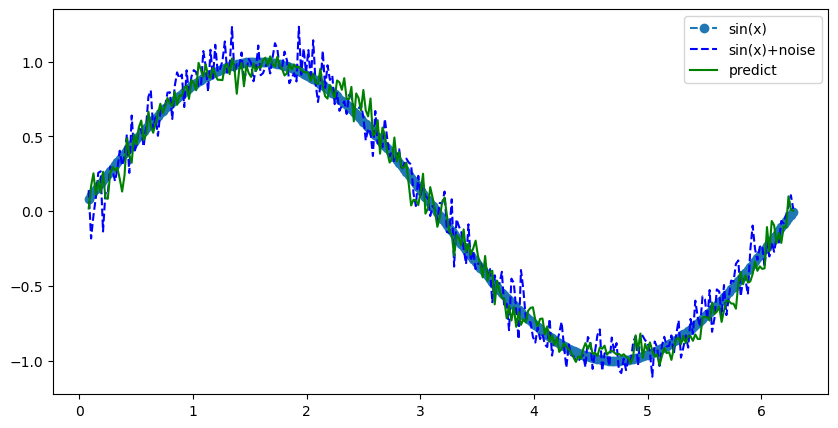

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(111)

# 获取原始x轴坐标
x = np.linspace(0, 6.28, 300)
x = x[4:]

# 真实sinx曲线
y_real=np.sin(x)
plt.plot(x,y_real,"o--", label='sin(x)')

# 带噪音的sinx曲线
plt.plot(x,cp.asnumpy(labels),"b--", label='sin(x)+noise')

# sinx的预测曲线
y_predict=[]
h_0.set_value(np.zeros((1, 3)))
c_0.set_value(np.zeros((1, 3)))
for i in range(N):
    for j in range(4):
        inputs[j].set_value(time_series[i, j])
    label.set_value(labels[i])
    output.forward()
    y_predict.append(cp.asnumpy(output.value)[0][0])
plt.plot(x,y_predict,"g-", label='predict')

plt.legend()